In [60]:
from typing import *
import os
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import swifter
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from IPython.display import display
from tqdm.notebook import tqdm
from nptyping import NDArray, Shape, Int, Float
from rich import print as rprint

sns.set(font='IPAexGothic', style='whitegrid')
colors = ['#de3838', '#007bc3', '#ffd12a']
markers = ['o', 'x', ',']
%config InlineBackend.figure_formats = ['svg']

cmap = sns.diverging_palette(255, 0, as_cmap=True)  # カラーパレットの定義
DATA_DIR = Path()/'..'/'..'/'data'
DF_DIR = DATA_DIR/'dataframes'

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [7]:
# 41

df_uselog_months = pd.read_pickle(DF_DIR/'uselog_months_k36.pkl')

def shift_month_count(df: pd.DataFrame, shift_period: int):
    df = df.copy()
    predict_data: pd.DataFrame = pd.DataFrame()
    year_months = df['年月'].unique()
    for i in range(shift_period, len(year_months)):
        temp = df.loc[df['年月']==year_months[i]].copy()
        temp.rename(columns={'count': 'target_count'}, inplace=True)
        for j in range(1, shift_period+1):
            temp_before = df.loc[df['年月']==year_months[i-j]].copy()
            del temp_before['年月']
            temp_before.rename(columns={'count': f'{j}m_ago_count'}, inplace=True)
            temp = pd.merge(temp, temp_before, on='customer_id', how='left')
        predict_data = pd.concat([predict_data, temp], ignore_index=True)
    return predict_data

df_uselog = shift_month_count(df=df_uselog_months, shift_period=1)
display(df_uselog)

df_uselog.to_pickle(DF_DIR/'uselog_k41.pkl')

,年月,customer_id,target_count,1m_ago_count
0,201805,AS002855,5,4.0
1,201805,AS009373,4,3.0
2,201805,AS015233,7,NaN
3,201805,AS015315,3,6.0
4,201805,AS015739,5,7.0
...,...,...,...,...
33846,201903,TS995853,8,11.0
33847,201903,TS998593,8,7.0
33848,201903,TS999079,3,2.0
33849,201903,TS999231,6,6.0


In [23]:
# 42

from dateutil.relativedelta import relativedelta

df_customer: pd.DataFrame = pd.read_pickle(DF_DIR/'customer_join_k30.pkl')
df_uselog: pd.DataFrame = pd.read_pickle(DF_DIR/'uselog_k41.pkl')

df_exit_customer: pd.DataFrame = df_customer[df_customer['is_deleted'] == 1].copy()
df_exit_customer['end_date'] = pd.to_datetime(df_exit_customer['end_date'])

def calc_exit_date(row: pd.Series) -> datetime:
    exit_date: datetime = row['end_date'] - relativedelta(months=1)
    return exit_date

df_exit_customer['exit_date'] = df_exit_customer.swifter.apply(calc_exit_date, axis=1)
df_exit_customer['年月'] = df_exit_customer['exit_date'].dt.strftime('%Y%m')

df_uselog['年月'] = df_uselog['年月'].astype(str)

df_exit_uselog: pd.DataFrame = pd.merge(df_uselog, df_exit_customer, on=['customer_id', '年月'], how='left')
df_exit_uselog = df_exit_uselog.dropna(subset=['name']).reset_index(drop=True)


display(df_exit_uselog.tail(2))

df_exit_uselog.to_pickle(DF_DIR/'exit_uselog_k42.pkl')

Pandas Apply:   0%|          | 0/1350 [00:00<?, ?it/s]

,年月,customer_id,target_count,1m_ago_count,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flag,calc_date,membership_period,exit_date
1102,201902,TS886985,5,3.0,XXX,C02,F,2018-03-01,2019-03-31,CA1,1.0,デイタイム,7500.0,通常,4.25,4.0,7.0,2.0,1.0,2019-03-31,12.0,2019-02-28
1103,201902,TS921837,2,3.0,XXXXXX,C01,M,2018-06-04,2019-03-31,CA2,1.0,オールタイム,10500.0,入会費半額,4.00,3.5,9.0,2.0,1.0,2019-03-31,9.0,2019-02-28


In [33]:
# 43

df_customer: pd.DataFrame = pd.read_pickle(DF_DIR/'customer_join_k30.pkl')
df_uselog: pd.DataFrame = pd.read_pickle(DF_DIR/'uselog_k41.pkl')
df_exit_uselog: pd.DataFrame = pd.read_pickle(DF_DIR/'exit_uselog_k42.pkl')

df_continue_costomer: pd.DataFrame = df_customer[df_customer['is_deleted'] == 0].copy()
df_continue_uselog: pd.DataFrame = pd.merge(df_uselog, df_continue_costomer, on=['customer_id'], how='left')
df_continue_uselog = df_continue_uselog.dropna(subset=['name']).reset_index(drop=True)
display(df_continue_uselog.tail(2))

df_continue_uselog = df_continue_uselog.sample(frac=1, random_state=0)
df_continue_uselog = df_continue_uselog.drop_duplicates(subset='customer_id').reset_index(drop=True)
display(df_continue_uselog.tail(2))

df_predict_data: pd.DataFrame = pd.concat([df_continue_uselog, df_exit_uselog], ignore_index=True)
display(df_predict_data.tail(2))

df_continue_uselog.to_pickle(DF_DIR/'continue_uselog_k43.pkl')
df_predict_data.to_pickle(DF_DIR/'predict_data_k43.pkl')

,年月,customer_id,target_count,1m_ago_count,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flag,calc_date,membership_period
27420,201903,TS999231,6,6.0,XXXX,C01,M,2017-03-01,NaT,CA1,0.0,オールタイム,10500.0,通常,4.666667,5.0,8.0,1.0,1.0,2019-04-30,25.0
27421,201903,TS999855,4,4.0,XXXXXX,C01,F,2017-04-01,NaT,CA1,0.0,オールタイム,10500.0,通常,4.583333,4.0,7.0,3.0,1.0,2019-04-30,24.0


,年月,customer_id,target_count,1m_ago_count,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flag,calc_date,membership_period
2840,201903,TS306264,11,NaN,XXXXX,C03,M,2019-03-06,NaT,CA1,0.0,ナイト,6000.0,通常,11.0,11.0,11.0,11.0,1.0,2019-04-30,1.0
2841,201903,IK259509,10,NaN,XXXX,C01,F,2019-03-06,NaT,CA1,0.0,オールタイム,10500.0,通常,10.0,10.0,10.0,10.0,1.0,2019-04-30,1.0


,年月,customer_id,target_count,1m_ago_count,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flag,calc_date,membership_period,exit_date
3944,201902,TS886985,5,3.0,XXX,C02,F,2018-03-01,2019-03-31,CA1,1.0,デイタイム,7500.0,通常,4.25,4.0,7.0,2.0,1.0,2019-03-31,12.0,2019-02-28
3945,201902,TS921837,2,3.0,XXXXXX,C01,M,2018-06-04,2019-03-31,CA2,1.0,オールタイム,10500.0,入会費半額,4.00,3.5,9.0,2.0,1.0,2019-03-31,9.0,2019-02-28


In [35]:
# 44

df_predict_data: pd.DataFrame = pd.read_pickle(DF_DIR/'predict_data_k43.pkl')

df_predict_data['now_date'] = pd.to_datetime(df_predict_data['年月'], format='%Y%m')

def calc_membership_period(row: pd.Series) -> int:
    start_date: datetime = row['start_date']
    now_date: datetime = row['now_date']
    delta: relativedelta = relativedelta(now_date, start_date)
    return delta.years*12 + delta.months

df_predict_data['period'] = df_predict_data.swifter.apply(calc_membership_period, axis=1)
display(df_predict_data.tail(2))

df_predict_data.to_pickle(DF_DIR/'predict_data_k44.pkl')

Pandas Apply:   0%|          | 0/3946 [00:00<?, ?it/s]

,年月,customer_id,target_count,1m_ago_count,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flag,calc_date,membership_period,exit_date,now_date,period
3944,201902,TS886985,5,3.0,XXX,C02,F,2018-03-01,2019-03-31,CA1,1.0,デイタイム,7500.0,通常,4.25,4.0,7.0,2.0,1.0,2019-03-31,12.0,2019-02-28,2019-02-01,11
3945,201902,TS921837,2,3.0,XXXXXX,C01,M,2018-06-04,2019-03-31,CA2,1.0,オールタイム,10500.0,入会費半額,4.00,3.5,9.0,2.0,1.0,2019-03-31,9.0,2019-02-28,2019-02-01,7


In [38]:
# 45

df_predict_data: pd.DataFrame = pd.read_pickle(DF_DIR/'predict_data_k44.pkl')

display(df_predict_data.isna().sum())
df_predict_data = df_predict_data.dropna(subset=['1m_ago_count'])
display(df_predict_data.isna().sum())

df_predict_data.to_pickle(DF_DIR/'predict_data_k45.pkl')

年月                      0
customer_id             0
target_count            0
1m_ago_count          255
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flag            0
calc_date               0
membership_period       0
exit_date            2842
now_date                0
period                  0
dtype: int64

年月                      0
customer_id             0
target_count            0
1m_ago_count            0
name                    0
class                   0
gender                  0
start_date              0
end_date             2639
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flag            0
calc_date               0
membership_period       0
exit_date            2639
now_date                0
period                  0
dtype: int64

In [42]:
# 46

df_predict_data: pd.DataFrame = pd.read_pickle(DF_DIR/'predict_data_k45.pkl')

target_columns = ['campaign_name', 'class_name', 'gender', '1m_ago_count', 'routine_flag', 'period', 'is_deleted']
df_predict_data = df_predict_data[target_columns]

display(df_predict_data.tail(2))

df_predict_data = pd.get_dummies(df_predict_data)
display(df_predict_data.tail(2))

df_predict_data = df_predict_data.drop(['campaign_name_通常', 'class_name_ナイト', 'gender_M'], axis=1)

display(df_predict_data.tail(2))

df_predict_data.to_pickle(DF_DIR/'predict_data_k46.pkl')

,campaign_name,class_name,gender,1m_ago_count,routine_flag,period,is_deleted
3944,通常,デイタイム,F,3.0,1.0,11,1.0
3945,入会費半額,オールタイム,M,3.0,1.0,7,1.0


,1m_ago_count,routine_flag,period,is_deleted,campaign_name_入会費半額,campaign_name_入会費無料,campaign_name_通常,class_name_オールタイム,class_name_デイタイム,class_name_ナイト,gender_F,gender_M
3944,3.0,1.0,11,1.0,0,0,1,0,1,0,1,0
3945,3.0,1.0,7,1.0,1,0,0,1,0,0,0,1


,1m_ago_count,routine_flag,period,is_deleted,campaign_name_入会費半額,campaign_name_入会費無料,class_name_オールタイム,class_name_デイタイム,gender_F
3944,3.0,1.0,11,1.0,0,0,0,1,1
3945,3.0,1.0,7,1.0,1,0,1,0,0


,y_test,y_pred
1091,0.0,1.0
1786,0.0,0.0
1439,0.0,0.0
745,1.0,1.0
820,1.0,0.0
...,...,...
1029,1.0,1.0
553,1.0,1.0
1570,0.0,0.0
82,1.0,1.0


model1
train score: 0.9759188846641318
test score: 0.8916349809885932
model2
train score: 0.9252217997465145
test score: 0.9201520912547528


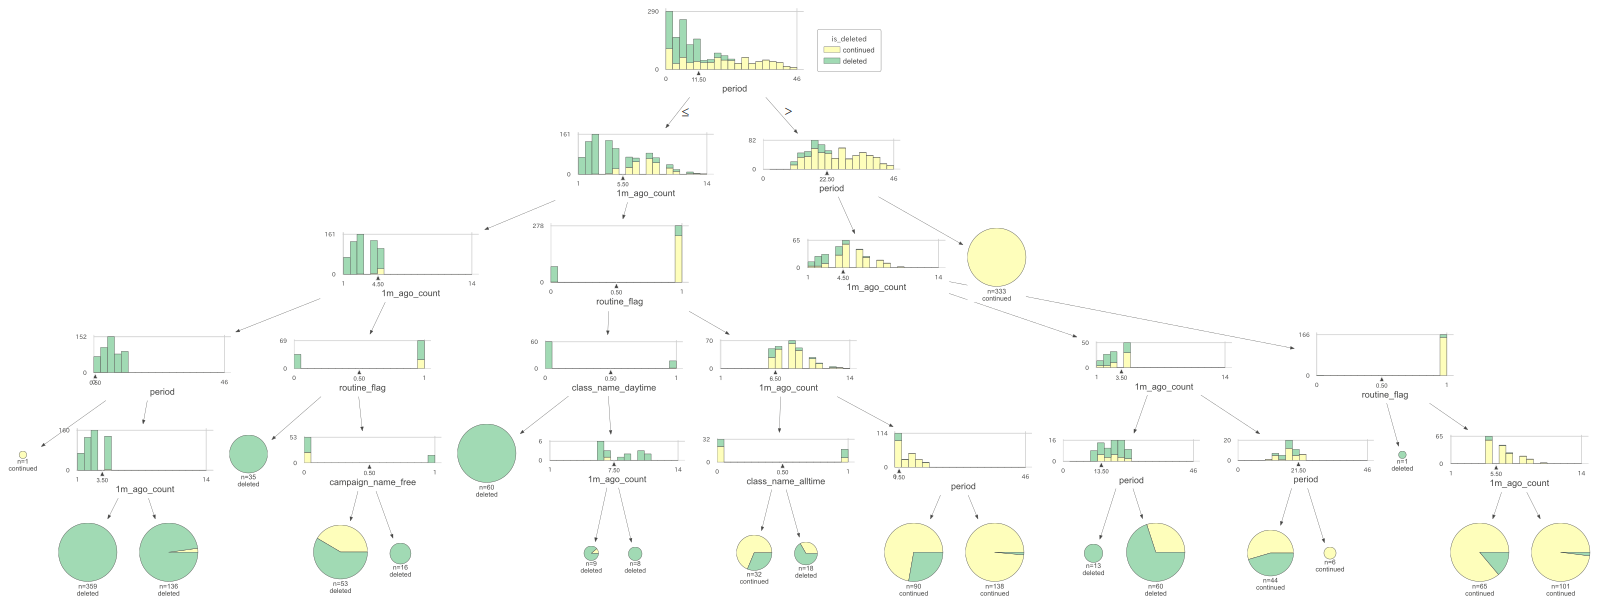

In [74]:
# 47

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


df_predict_data: pd.DataFrame = pd.read_pickle(DF_DIR/'predict_data_k46.pkl')

df_exit = df_predict_data[df_predict_data['is_deleted'] == 1].copy()
df_continue = df_predict_data[df_predict_data['is_deleted'] == 0].copy().sample(len(df_exit), random_state=0)
df = pd.concat([df_exit, df_continue], ignore_index=True)

X = df.drop(['is_deleted'], axis=1)
y = df['is_deleted']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)

df_results_test = pd.DataFrame({'y_test': y_test, 'y_pred': y_test_pred})
display(df_results_test)


# 48
print('model1')
print(f'train score: {model.score(X_train, y_train)}')
print(f'test score: {model.score(X_test, y_test)}')

model = DecisionTreeClassifier(random_state=0, max_depth=5)
model.fit(X_train.values, y_train.values)

print('model2')
print(f'train score: {model.score(X_train.values, y_train.values)}')
print(f'test score: {model.score(X_test.values, y_test.values)}')


# 49
from dtreeviz.trees import dtreeviz

X_train = X_train.rename(columns={
    'campaign_name_入会費半額': 'campaign_name_half-price',
    'campaign_name_入会費無料': 'campaign_name_free',
    'class_name_オールタイム': 'class_name_alltime',
    'class_name_デイタイム': 'class_name_daytime'})

viz = dtreeviz(
    tree_model=model,
    x_data=X_train,
    y_data=y_train,
    feature_names=X_train.columns,
    target_name='is_deleted',
    class_names=['continued', 'deleted']
)
display(viz)
viz.save('tree.svg')